# Data preprocessing

In [364]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import union_categoricals

from mj import utils

### Read dataset

In [365]:
data = pd.read_csv('../data/processed_data/processed_data_2015_onward_mean.csv')

In [366]:
data.head(20)

,EventDate,Actor1CountryCode,Actor2CountryCode,GoldsteinScale_Averaged,AvgTone_Averaged,NumMentions_averaged,NumArticles_averaged
0,2015-01-31,AFG,PAK,1.062500,0.275670,4.125000,4.125000
1,2015-01-31,AFG,USA,1.693333,-1.697247,7.933333,7.933333
2,2015-01-31,AFR,BDI,-1.000000,0.353357,5.000000,5.000000
3,2015-01-31,AFR,USA,2.800000,5.889282,10.000000,10.000000
4,2015-01-31,AFR,ZAF,-10.000000,-5.931919,4.000000,4.000000
5,2015-01-31,ARM,BGR,3.400000,2.430847,5.000000,5.000000
6,2015-01-31,AUS,ARE,-10.000000,-5.566219,3.000000,3.000000
7,2015-01-31,AUS,USA,1.000000,4.019882,5.500000,5.500000
8,2015-01-31,BFA,CIV,3.400000,-4.093567,6.000000,6.000000
9,2015-01-31,BHR,ARE,-10.000000,-13.043478,6.000000,6.000000


### Alphabetical order transformation

### Remove tuples that contain the same two countries but in different order by averaging the values from both tuples (ex. AFG - PAK and PAK - AFG)

In [367]:
data[['Actor1CountryCode', 'Actor2CountryCode']] = \
    data[['Actor1CountryCode', 'Actor2CountryCode']].apply(
        lambda x: sorted(x), axis=1, result_type='expand'
    )

In [368]:
data = data.groupby(['EventDate', 'Actor1CountryCode', 'Actor2CountryCode'])[
    ['GoldsteinScale_Averaged', 'AvgTone_Averaged', 'NumMentions_averaged',
     'NumArticles_averaged']].mean().reset_index()

In [369]:
data.head(5)

,EventDate,Actor1CountryCode,Actor2CountryCode,GoldsteinScale_Averaged,AvgTone_Averaged,NumMentions_averaged,NumArticles_averaged
0,2015-01-31,AFG,PAK,1.827083,-0.594263,4.270833,4.270833
1,2015-01-31,AFG,USA,2.575833,-1.874094,6.758333,6.758333
2,2015-01-31,AFR,BDI,-1.000000,0.353357,5.000000,5.000000
3,2015-01-31,AFR,DJI,5.200000,-1.477833,3.000000,3.000000
4,2015-01-31,AFR,NGA,1.000000,-2.072539,6.000000,6.000000


### Familiarization

In [370]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239911 entries, 0 to 239910
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   EventDate                239911 non-null  object 
 1   Actor1CountryCode        239911 non-null  object 
 2   Actor2CountryCode        239911 non-null  object 
 3   GoldsteinScale_Averaged  239911 non-null  float64
 4   AvgTone_Averaged         239911 non-null  float64
 5   NumMentions_averaged     239911 non-null  float64
 6   NumArticles_averaged     239911 non-null  float64
dtypes: float64(4), object(3)
memory usage: 12.8+ MB


In [371]:
data.describe()

,GoldsteinScale_Averaged,AvgTone_Averaged,NumMentions_averaged,NumArticles_averaged
count,239911.000000,239911.000000,239911.000000,239911.000000
mean,1.285411,-1.009916,5.150839,5.048537
std,3.433031,3.731656,3.026468,2.871697
min,-10.000000,-23.469388,1.000000,1.000000
25%,0.000000,-3.333333,3.125000,3.050000
50%,1.700000,-1.062417,5.000000,4.872727
75%,3.400000,1.326219,6.000000,6.000000
max,10.000000,21.052632,275.000000,275.000000


In [372]:
data.shape

(239911, 7)

# Graph building

In [373]:
# extract nodes from data - the unique country codes
a1 = pd.Categorical(data['Actor1CountryCode'])
a2 = pd.Categorical(data['Actor2CountryCode'])
nodes = union_categoricals([a1, a2]).categories.to_list()
nodes

['ABW',
 'AFG',
 'AFR',
 'AGO',
 'AIA',
 'ALB',
 'AND',
 'ARE',
 'ARG',
 'ARM',
 'ASA',
 'ATG',
 'AUS',
 'AUT',
 'AZE',
 'BDI',
 'BEL',
 'BEN',
 'BFA',
 'BGD',
 'BGR',
 'BHR',
 'BHS',
 'BLR',
 'BLZ',
 'BMU',
 'BOL',
 'BRA',
 'BRB',
 'BRN',
 'BTN',
 'BWA',
 'CAF',
 'CAN',
 'CAS',
 'CAU',
 'CHE',
 'CHL',
 'CHN',
 'CIV',
 'CMR',
 'COD',
 'COG',
 'COK',
 'COL',
 'COM',
 'CPV',
 'CRB',
 'CRI',
 'CUB',
 'CYM',
 'CYP',
 'CZE',
 'DEU',
 'DJI',
 'DMA',
 'DNK',
 'DOM',
 'DZA',
 'EAF',
 'ECU',
 'EGY',
 'ERI',
 'ESP',
 'EST',
 'ETH',
 'EUR',
 'FIN',
 'FJI',
 'FRA',
 'FSM',
 'GAB',
 'GBR',
 'GEO',
 'GHA',
 'GIN',
 'GMB',
 'GNB',
 'GNQ',
 'GRC',
 'GRD',
 'GTM',
 'GUY',
 'HKG',
 'HND',
 'HRV',
 'HTI',
 'HUN',
 'IDN',
 'IND',
 'IRL',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JOR',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'KHM',
 'KIR',
 'KNA',
 'KOR',
 'KWT',
 'LAM',
 'LAO',
 'LBN',
 'LBR',
 'LBY',
 'LCA',
 'LIE',
 'LKA',
 'LSO',
 'LTU',
 'LUX',
 'LVA',
 'MAC',
 'MAR',
 'MCO',
 'MDA',
 'MDG',
 'MDV',


In [374]:
g = nx.MultiGraph()

In [375]:
g.nodes

NodeView(())

In [376]:
g.edges

MultiEdgeView([])

# Linear combination between features:
#### F = 0.7 * GoldsteinScale_Averaged + 0.2 * AvgTone_Averaged + 0.05 * NumMentions_averaged + 0.05 * NumArticles_averaged

In [377]:
filtered_data = utils.filter_data(data, '2015-01-31')

for _, row in filtered_data.iterrows():
    g.add_edge(row.iloc[1], row.iloc[2], utils.linear_combination(row))


In [378]:
g.edges

MultiEdgeView([('AFG', 'PAK', 1.5871889963209842), ('AFG', 'USA', 2.104097936284729), ('PAK', 'CHN', 3.4600600600600595), ('PAK', 'MEX', -1.702641509433962), ('PAK', 'SAU', -7.479220779220777), ('PAK', 'USA', 0.9415730337078659), ('USA', 'AFR', 3.8228563015312136), ('USA', 'AUS', 2.053976308223153), ('USA', 'BGD', -0.711475409836064), ('USA', 'BLR', -4.7401625070464), ('USA', 'BLZ', -0.460059171597632), ('USA', 'CAN', 3.4917986714358706), ('USA', 'CHE', 5.610451127819548), ('USA', 'CHL', 1.24232613908873), ('USA', 'CHN', -2.12096852990022), ('USA', 'COD', -3.9319137887959257), ('USA', 'COK', -0.652631578947368), ('USA', 'COL', -4.2126410835214445), ('USA', 'CUB', 3.6656794799951076), ('USA', 'DEU', 0.45337181049936304), ('USA', 'EGY', 5.364317180616739), ('USA', 'ESP', 1.1016074950690347), ('USA', 'EUR', 3.900011888089584), ('USA', 'FRA', -3.7283125511828077), ('USA', 'GBR', 1.1050185858435015), ('USA', 'GRC', 1.8224647887323937), ('USA', 'HKG', 1.3040332512315271), ('USA', 'IRN', 4.53

In [379]:
for (u, v, d) in g.edges:
    print((u, v, d))

('AFG', 'PAK', 1.5871889963209842)
('AFG', 'USA', 2.104097936284729)
('PAK', 'CHN', 3.4600600600600595)
('PAK', 'MEX', -1.702641509433962)
('PAK', 'SAU', -7.479220779220777)
('PAK', 'USA', 0.9415730337078659)
('USA', 'AFR', 3.8228563015312136)
('USA', 'AUS', 2.053976308223153)
('USA', 'BGD', -0.711475409836064)
('USA', 'BLR', -4.7401625070464)
('USA', 'BLZ', -0.460059171597632)
('USA', 'CAN', 3.4917986714358706)
('USA', 'CHE', 5.610451127819548)
('USA', 'CHL', 1.24232613908873)
('USA', 'CHN', -2.12096852990022)
('USA', 'COD', -3.9319137887959257)
('USA', 'COK', -0.652631578947368)
('USA', 'COL', -4.2126410835214445)
('USA', 'CUB', 3.6656794799951076)
('USA', 'DEU', 0.45337181049936304)
('USA', 'EGY', 5.364317180616739)
('USA', 'ESP', 1.1016074950690347)
('USA', 'EUR', 3.900011888089584)
('USA', 'FRA', -3.7283125511828077)
('USA', 'GBR', 1.1050185858435015)
('USA', 'GRC', 1.8224647887323937)
('USA', 'HKG', 1.3040332512315271)
('USA', 'IRN', 4.537656903765689)
('USA', 'ISR', 1.2512446996

In [380]:
def show_graph(g):
    # uncomment this line if you want to see the full graph
    # esmall=[(u,v) for (u,v,d) in g.edges if d < 0]
    elarge = [(u, v) for (u, v, d) in g.edges if d >= 0]

    plt.figure(figsize=(30, 50))
    pos = nx.circular_layout(g)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(g, pos, node_size=1000)

    # edges
    # uncomment this line if you want to see the full graph
    # nx.draw_networkx_edges(g,pos,edgelist=esmall,
    #                     width=6,alpha=0.5, edge_color='b',style='dashed')

    nx.draw_networkx_edges(g, pos, edgelist=elarge,
                           width=6, edge_color='r', style='solid')

    # labels
    nx.draw_networkx_labels(g, pos, font_size=7, font_family='sans-serif')

    plt.axis('off')
    plt.show()  # display

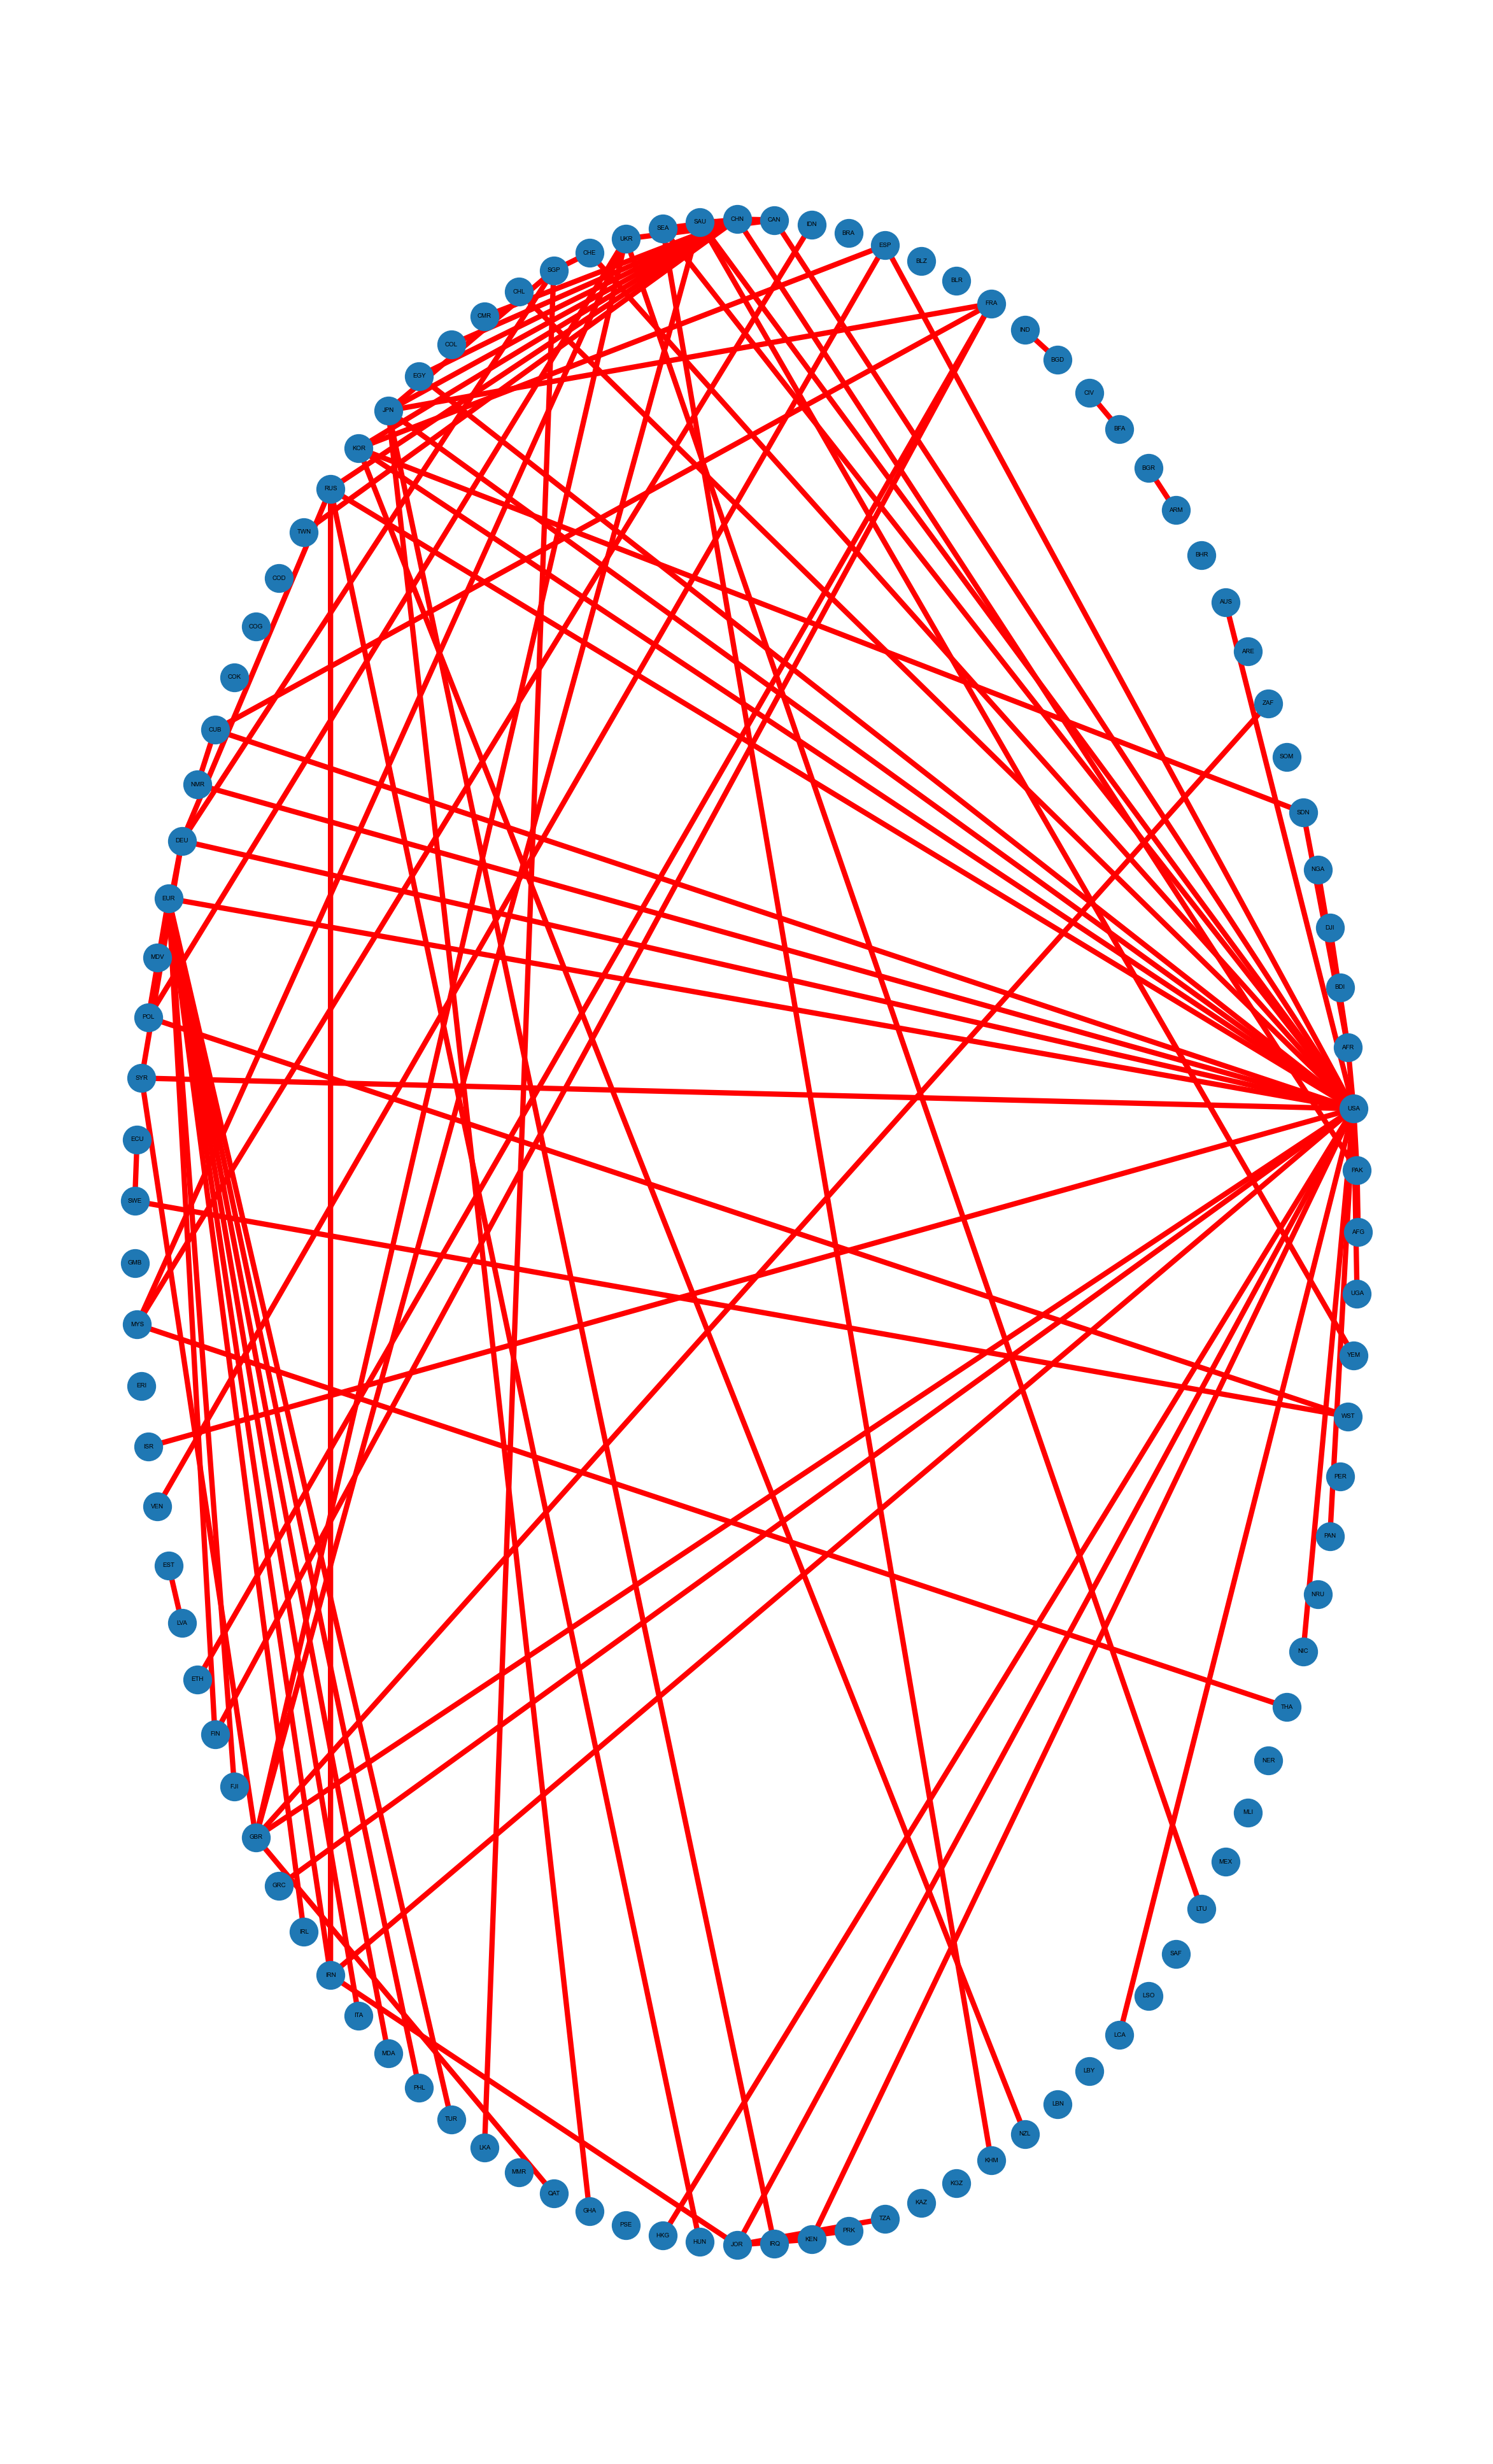

In [381]:
show_graph(g)

In [382]:
weights = [d for (u, v, d) in g.edges]
weights

[1.5871889963209842,
 2.104097936284729,
 3.4600600600600595,
 -1.702641509433962,
 -7.479220779220777,
 0.9415730337078659,
 3.8228563015312136,
 2.053976308223153,
 -0.711475409836064,
 -4.7401625070464,
 -0.460059171597632,
 3.4917986714358706,
 5.610451127819548,
 1.24232613908873,
 -2.12096852990022,
 -3.9319137887959257,
 -0.652631578947368,
 -4.2126410835214445,
 3.6656794799951076,
 0.45337181049936304,
 5.364317180616739,
 1.1016074950690347,
 3.900011888089584,
 -3.7283125511828077,
 1.1050185858435015,
 1.8224647887323937,
 1.3040332512315271,
 4.537656903765689,
 1.2512446996318929,
 1.2020610278372579,
 2.1973425557070816,
 5.755329949238577,
 3.2019022794220096,
 0.651572327044024,
 -1.0388131264910054,
 -5.776190476190476,
 3.1546759639048396,
 3.652332439678284,
 0.765395894428154,
 -4.223502672824467,
 -4.118867924528302,
 2.9125305009815015,
 1.8184987316871148,
 3.161904761904762,
 1.850027378575394,
 -3.1290024937655865,
 0.796618571302115,
 -2.924092409240924,
 -0.

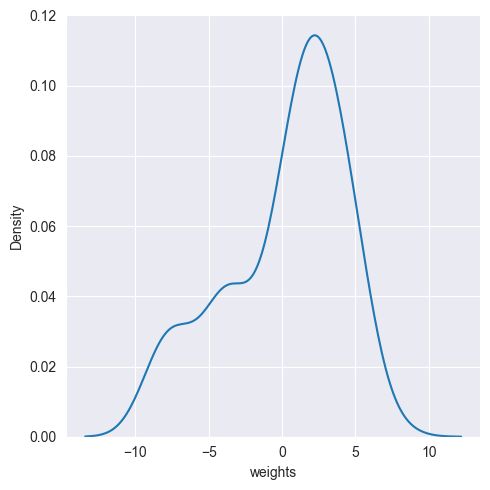

In [383]:
# draw edge weight distribution
sns.displot(pd.DataFrame(
    {
        'weights': weights
    }, 
),
    x='weights', kind='kde'
)

## Create graphs for four months

In [384]:
import pickle

In [385]:
months = ['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30']

for month in months:
    filtered_data = utils.filter_data(data, month)
    g = nx.MultiGraph()
    for _, row in filtered_data.iterrows():
        g.add_edge(row.iloc[1], row.iloc[2], utils.linear_combination(row))
    with open(f'../data/graphs/graph_{month}.pkl', 'wb') as f:
        pickle.dump(g, f)

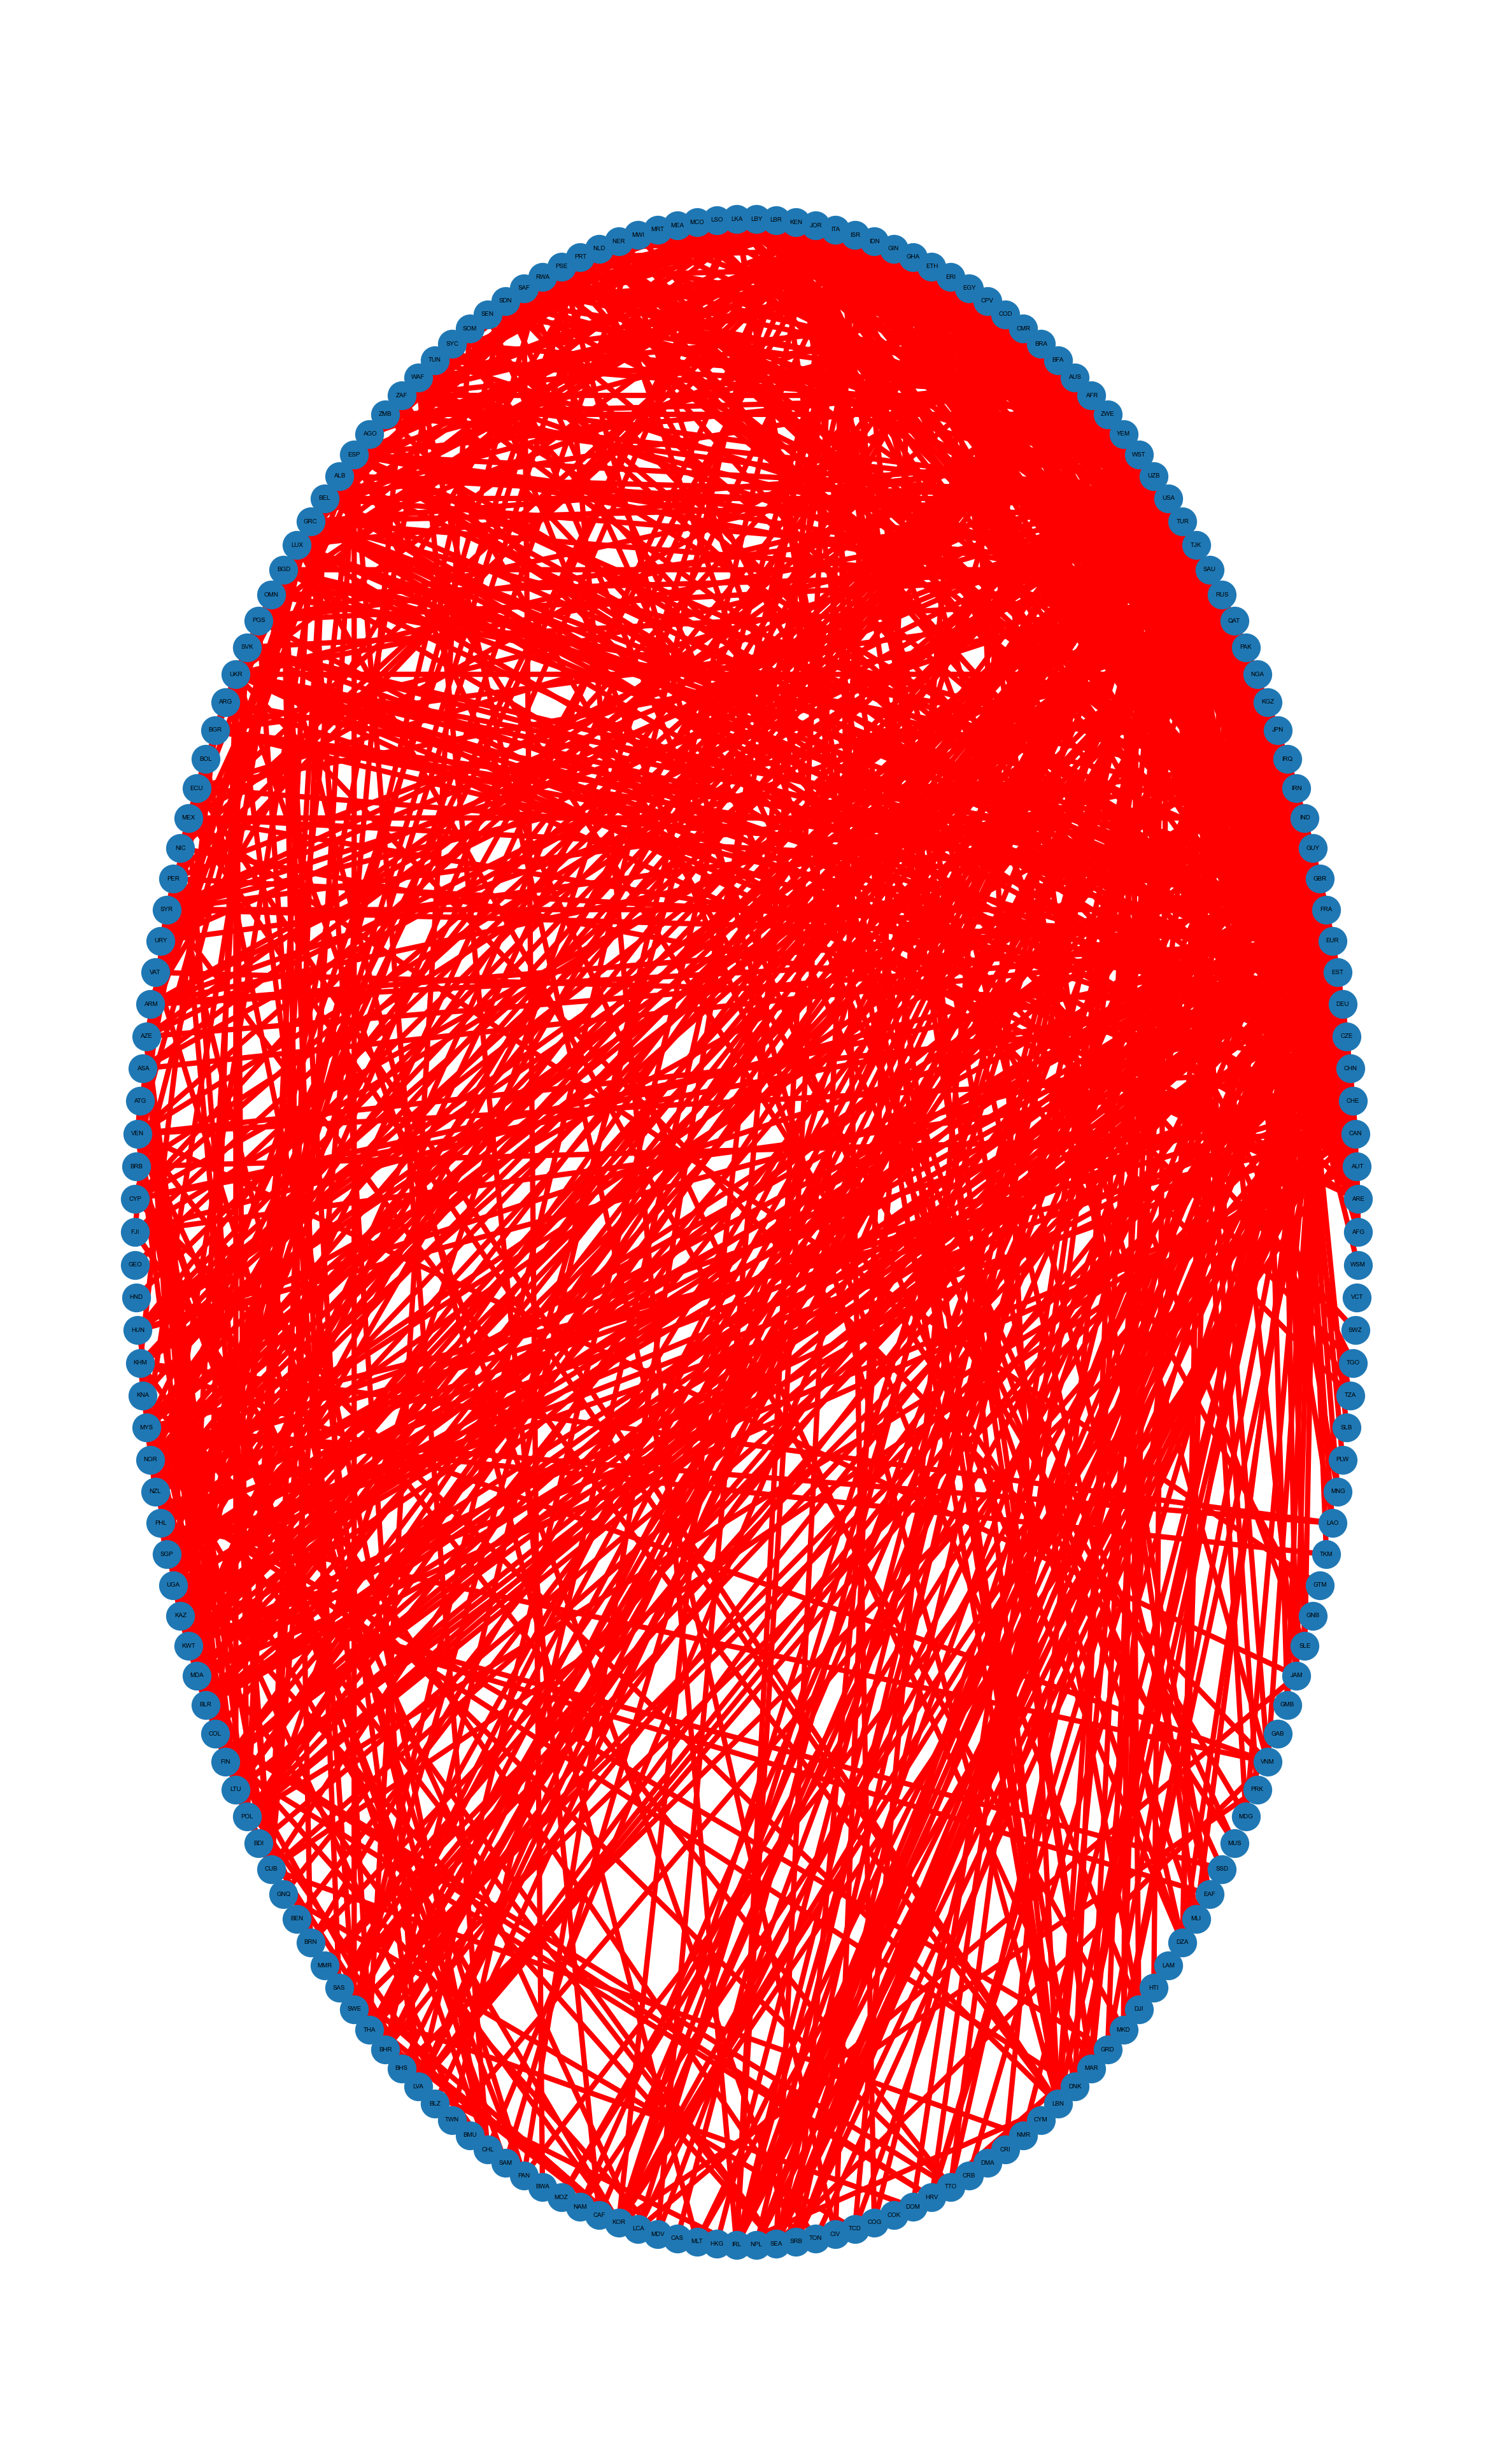

In [386]:
with open('../data/graphs/graph_2015-02-28.pkl', 'rb') as f:
    g = pickle.load(f)
    show_graph(g)